## 전력수요예측

### 목차

* 1. Data ETL (Extract, Transform, Load) <br>
    1.1 데이터 시간 index 확인 및 format 설정 <br>
    1.2 Data Quality 확인 (Missing Values, Duplicate Values etc) <br>
    1.3 도표 통해 기초 통계 정보 분석 (Trend, Seasonality etc) <br><br>
* 2. 시계열 모델 제작 (Fit Model) <br>
    2.1 모델 가정 확인 <br>
    2.2 Stationarity Test (Augmented Dickey-Fuller test, ACF/PACF 표 확인) <br>
    2.3 Seasonality 확인 <br>
    2.4 적합한 모델 종류 선택 <br>
    2.5 여러 parameter 비교 및 선택 (AIC, BIC) <br><br>
* 3. 수요 에측 (Forecast Demand)

## Data 로드

In [1]:
## module import
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame #데이터 전처리 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [3]:
## 'Time' column을 index로
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

In [4]:
train.shape

(16909, 1301)

> 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량

In [5]:
train.head()

,Time,X692,X1272,X553,X1299,X4,X598,X1003,X1010,X1216,X1047,X381,X466,X1420,X686,X711,X1251,X828,X1350,X1066,X1293,X1148,X451,X174,X74,X626,X1083,X1000,X632,X1380,X607,X680,X977,X492,X968,X891,X122,X489,X86,X392,X1007,X549,X1343,X437,X551,X287,X138,X339,X1210,X127,...,X1482,X23,X441,X1070,X707,X493,X785,X873,X1179,X1125,X109,X224,X1259,X1143,X1324,X889,X689,X447,X1270,X827,X1037,X942,X1498,X678,X1100,X239,X1369,X436,X536,X933,X1035,X1194,X1441,X291,X1328,X1323,X616,X1195,X944,X1017,X1164,X656,X1287,X324,X767,X1271,X1288,X58,X1033,X1163
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 결측치 파악 (train,test)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


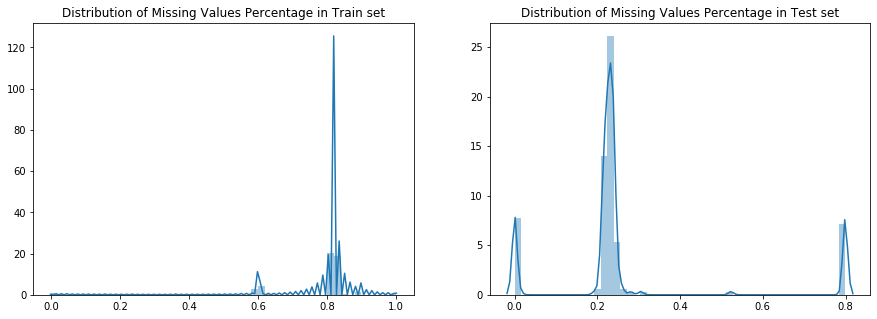

In [6]:
_, ax = plt.subplots(1,2, figsize=(15,5)) #train, test를 한 번에 비교하기 위해, 그래프 창을 2개로 만듭니다.
# train.isnull().mean(axis=0) #각 세대별 이름과 결측치 비율이 나열됩니다.
sns.distplot(train.isnull().mean(axis=0), ax=ax[0]) #나열된 값을 distplot을 이용해 시각화 하고, 이를 첫 번째 그래프 창에 넣습니다.
ax[0].set_title('Distribution of Missing Values Percentage in Train set')

sns.distplot(test.isnull().mean(axis=0), ax=ax[1]) #test data에서의 결측치 비율을 시각화 하고, 이를 두 번째 그래프 창에 넣습니다.
ax[1].set_title('Distribution of Missing Values Percentage in Test set')
plt.show()

#### 결측값 채우기

> * NA가 발생한 경우, 직전 시간의 전력사용량 값이 상당히 큰 경향이 있습니다. 이는 미터링 데이터 수집 시스템의 특징으로 볼 수 있음
* 직전 시간의 사용량이 과다가 아닌 경우의 결측값을 채우는 방법도 필요

In [7]:

for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

    df=DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )

    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중
250 번째 실행중
300 번째 실행중
350 번째 실행중
400 번째 실행중
450 번째 실행중
500 번째 실행중
550 번째 실행중
600 번째 실행중
650 번째 실행중
700 번째 실행중
750 번째 실행중
800 번째 실행중
850 번째 실행중
900 번째 실행중
950 번째 실행중
1000 번째 실행중
1050 번째 실행중
1100 번째 실행중
1150 번째 실행중
1200 번째 실행중
1250 번째 실행중
1300 번째 실행중


In [8]:
# 결측치 채운후, 18년 2월15일부터의 시계열 그래프 생성

# Time컬럼 datetime형식으로 변환 후, 인덱스로
train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time', inplace=True) # Date를 인덱스로
train_sample = train['2018-02-15':]

# 나머지 결측치는 시간 기준 결측값 보간법
train_sample = train_sample.interpolate(method='time')

In [9]:
#결측값 가진 행 제거 - ???
train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

Index(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'],
      dtype='object')

In [10]:
train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

> 'X692' 세대를 sample로 모델링 , 일별 사용량 예측 테스트

In [11]:
## 일별 esampling

# 2018-02-15 ~ 2018-06-30 까지의 일별 전력수요량 합계
train_sample['X692'].resample(rule='D').sum()

Time
2018-02-15    12.2420
2018-02-16    12.0700
2018-02-17    10.4200
2018-02-18     9.0560
2018-02-19     8.7365
               ...   
2018-06-26     9.6970
2018-06-27     8.8540
2018-06-28     9.6020
2018-06-29    11.2725
2018-06-30     7.6970
Freq: D, Name: X692, Length: 136, dtype: float64

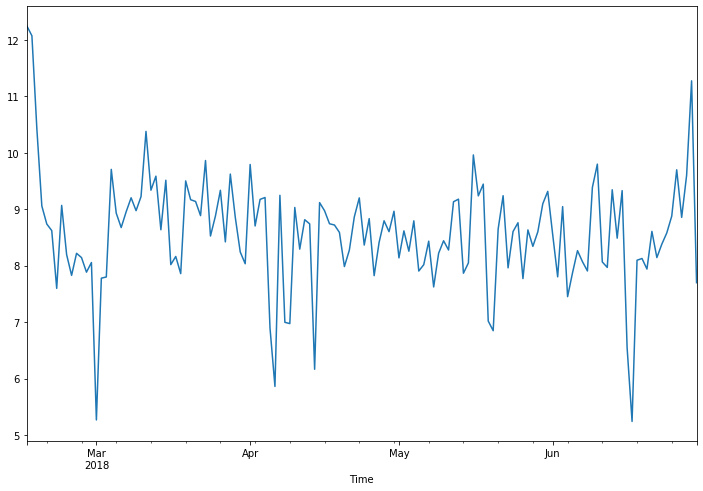

In [12]:
train_sample['X692'].resample(rule='D').sum().plot(figsize=(12,8))

In [13]:
## demcopose

def plot_decompose(decomposeresult):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8))
    decomposeresult.observed.plot(legend=False, ax=ax1)
    ax1.set_ylabel('Observed')
    decomposeresult.trend.plot(legend=False, ax=ax2)
    ax2.set_ylabel('Trend')
    decomposeresult.seasonal.plot(legend=False, ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposeresult.resid.plot(legend=False, ax=ax4)
    ax4.set_ylabel('resid')

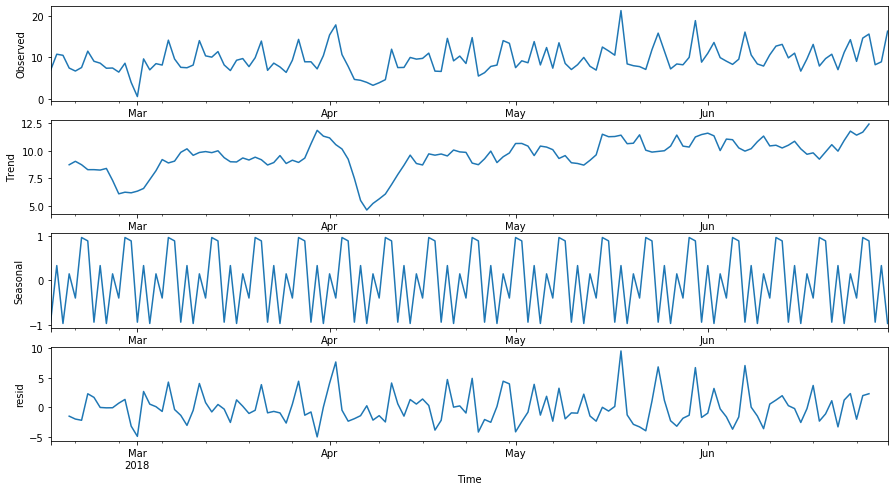

In [14]:
# 일별 집계데이터 decomposing
decomposition = seasonal_decompose(train_sample['X694'].resample(rule='D').sum())
plot_decompose(decomposition)

In [15]:
## differencing

# stationary check def
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else :
        print('Non-Stationary {}'.format(result[1]))

In [16]:
adf_check(train_sample['X694'].resample(rule='D').sum())

Stationary 5.463820005668163e-15


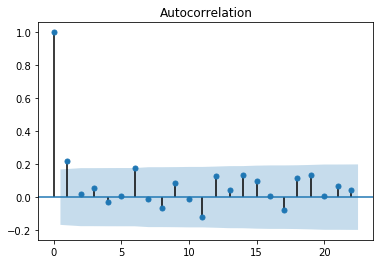

In [17]:
plot_acf(train_sample['X694'].resample(rule='D').sum()); # AutoCorrelation

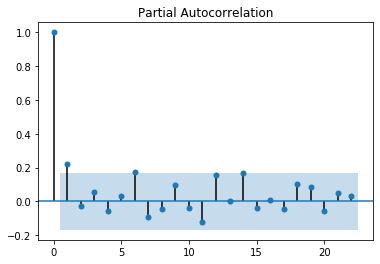

In [18]:
plot_pacf(train_sample['X694'].resample(rule='D').sum(), method='ywm'); # Partial Autocorrelation

In [19]:
p = list(range(0,5))
d = [0]
q = [0,1]

pdq = list(itertools.product(p,d,q))

In [20]:
for param in pdq:
    model = ARIMA(train_sample['X694'].resample(rule='D').sum(), order=param)
    result = model.fit(disp=0)
    print('ARIMA{} => AIC : {}'.format(param,result.aic))

C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which

ARIMA(0, 0, 0) => AIC : 705.6181171190108
ARIMA(0, 0, 1) => AIC : 700.463133148643
ARIMA(1, 0, 0) => AIC : 700.7497407083833
ARIMA(1, 0, 1) => AIC : 702.4510797398652
ARIMA(2, 0, 0) => AIC : 702.6167914242573
ARIMA(2, 0, 1) => AIC : 704.3166640918232
ARIMA(3, 0, 0) => AIC : 704.1531384484573
ARIMA(3, 0, 1) => AIC : 705.9799092394801
ARIMA(4, 0, 0) => AIC : 705.7821580988659
ARIMA(4, 0, 1) => AIC : 708.0301586785539


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [39]:
X = train_sample['X694'].resample(rule='D').sum().values
size = int(len(X)*0.76)
train_sample_1,test_sample_1 = X[:size],X[size:] # train_sample_1 => 앞쪽 23개 

In [40]:
history = [x for x in train_sample_1] # train은 그대로 두고 (복사본 생성)

In [41]:
predictions = []

for t in range(len(test_sample_1)): # test사이즈만큼 prediction
    model = ARIMA(history, order=(0,0,1))
    result = model.fit(disp=0) # disp=0 => warnning메세지 안뜨게
    output = result.forecast() # forcast default인자는 1임 # 즉, 다음거 하나만 예측 # 배열로 저장됨
    yhat = output[0] # yhat => 예측값
    predictions.append(yhat)
    
    # 계속해서 다음꺼 예측하기 위해
    obs = test_sample_1[t] 
    history.append(obs) # 하나씪 범위 늘림

In [42]:
predictions

[array([8.91527122]),
 array([9.38248296]),
 array([11.5377251]),
 array([8.65046152]),
 array([9.72937968]),
 array([10.14020738]),
 array([9.23118872]),
 array([9.24214254]),
 array([9.05598312]),
 array([9.38298741]),
 array([10.87034575]),
 array([9.27495317]),
 array([9.13323393]),
 array([9.03682805]),
 array([9.68988293]),
 array([10.0589639]),
 array([10.11685415]),
 array([9.33429175]),
 array([9.80283119]),
 array([8.65980041]),
 array([9.61008314]),
 array([10.23750084]),
 array([8.8739443]),
 array([9.59322904]),
 array([9.6800479]),
 array([8.79599241]),
 array([9.94316614]),
 array([10.44320121]),
 array([9.12666014]),
 array([10.68693869]),
 array([10.68100128]),
 array([8.94741839]),
 array([9.50988193])]

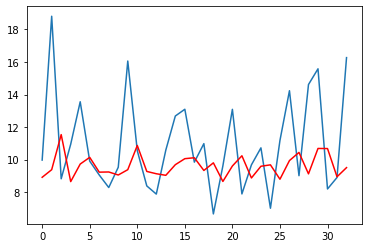

In [43]:
plt.plot(test_sample_1)
plt.plot(predictions,color='red')

In [44]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_sample_1,predictions)

In [45]:
rmse = np.sqrt(error)
rmse

3.295459520790306